In [1]:
############## Step 1: training the model
# Import libraries
import sys
import math
import cv2
import copy
import random
import keras
import numpy as np
import tensorflow as tf
from sklearn.metrics import average_precision_score, precision_recall_curve
# Minimum tensorflow version
MINIMUM_TF_VERSION = 1, 12, 0
# Restrict tensortlow to only use the one GPU
def setup_gpu(gpu_id):
    if tf_version_ok((2, 0, 0)):
        if gpu_id == 'cpu' or gpu_id == -1:
            tf.config.experimental.set_visible_devices([], 'GPU')
            return
        # Get all gpus
        gpus = tf.config.experimental.list_physical_devices('GPU')
        if gpus:
            # Restrict TensorFlow to only use the first GPU.
            try:
                # Currently, memory growth needs to be the same across GPUs.
                for gpu in gpus:
                    #tf.config.experimental.set_virtual_device_configuration(gpu, [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4096)])
                    tf.config.experimental.set_memory_growth(gpu, True)
                # Use only the selcted gpu.
                tf.config.experimental.set_visible_devices(gpus[gpu_id], 'GPU')
            except RuntimeError as e:
                # Visible devices must be set before GPUs have been initialized.
                print(e)
            logical_gpus = tf.config.experimental.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    else:
        import os
        if gpu_id == 'cpu' or gpu_id == -1:
            os.environ['CUDA_VISIBLE_DEVICES'] = ""
            return
        os.environ['CUDA_VISIBLE_DEVICES'] = str(gpu_id)
        config = tf.ConfigProto()
        config.gpu_options.per_process_gpu_memory_fraction = 0.5
        config.gpu_options.allow_growth = True
        tf.keras.backend.set_session(tf.Session(config=config))
# Get the Tensorflow version
def tf_version():
    return tuple(map(int, tf.version.VERSION.split('-')[0].split('.')))
# Check if the current Tensorflow version is higher than the minimum version
def tf_version_ok(minimum_tf_version=MINIMUM_TF_VERSION):
    return tf_version() >= minimum_tf_version
# This class is used for configuration
class Config:
    # Initializes the class
    def __init__(self):
        # Print the process or not
        self.verbose = True
        # Settings for data augmentation
        self.use_horizontal_flips = False
        self.use_vertical_flips = False
        self.rot_90 = False
        # Anchor box scales
        # Note that if im_size is smaller, anchor_box_scales should be scaled
        # Original anchor_box_scales in the paper is [128, 256, 512]
        self.anchor_box_scales = [36, 49, 60] 
        # Anchor box ratios
        self.anchor_box_ratios = [[1.9,1.45],[2.2,1.6],[2.5,1.75]]
        # Size to resize the smallest side of the image
        # Original setting in paper is 600. Set to 300 in here to save training time
        self.im_size = 300
        # image channel-wise mean to subtract
        self.img_channel_mean = [103.939, 116.779, 123.68]
        self.img_scaling_factor = 1.0
        # number of ROIs at once
        self.num_rois = 4
        # stride at the RPN (this depends on the network configuration)
        self.rpn_stride = 16
        # scaling the stdev
        self.std_scaling = 4.0
        self.classifier_regr_std = [8.0, 8.0, 4.0, 4.0]
        # overlaps for RPN
        self.rpn_min_overlap = 0.5
        self.rpn_max_overlap = 0.88
        # overlaps for classifier ROIs
        self.classifier_min_overlap = 0.1
        self.classifier_max_overlap = 0.5
        # Loss function settings
        self.lambda_rpn_regr = 1.0
        self.lambda_rpn_class = 1.0
        self.lambda_cls_regr = 1.0
        self.lambda_cls_class = 1.0
        self.epsilon = 1e-4
        # Paths
        self.annotations_file_path = None
        self.img_base_path = None
        self.pretrained_model_path = None
        self.model_path = None
        self.records_path = None
# Parse the data from annotation file
def get_data(input_path):
	
  found_bg = False
  all_imgs = {}

  classes_count = {}

  class_mapping = {}

  visualise = True

  i = 1
	
  with open(input_path,'r') as f:
    print('Parsing annotation files')
    
    for line in f:
      
      # Print process
      sys.stdout.write('\r'+'idx=' + str(i))
      i += 1
      line_split = line.strip().split(',')
			# Make sure the info saved in annotation file matching the format (path_filename, x1, y1, x2, y2, class_name)
			# Note:
			#	One path_filename might has several classes (class_name)
			#	x1, y1, x2, y2 are the pixel value of the origial image, not the ratio value
			#	(x1, y1) top left coordinates; (x2, y2) bottom right coordinates
			#   x1,y1-------------------
			#	|						|
			#	|						|
			#	|						|
			#	|						|
			#	---------------------x2,y2
      (filename,x1,y1,x2,y2,class_name) = line_split
      
      if class_name not in classes_count:
        classes_count[class_name] = 1
      else:
        classes_count[class_name] += 1

      if class_name not in class_mapping:
        if class_name == 'bg' and found_bg == False:
          print('Found class name with special name bg. Will be treated as a background region (this is usually for hard negative mining).')
          found_bg = True
        class_mapping[class_name] = len(class_mapping)

      if filename not in all_imgs:
        all_imgs[filename] = {}
				
        img = cv2.imread(filename)
        (rows,cols) = img.shape[:2]
        all_imgs[filename]['filepath'] = filename
        all_imgs[filename]['width'] = cols
        all_imgs[filename]['height'] = rows
        all_imgs[filename]['bboxes'] = []
				# if np.random.randint(0,6) > 0:
				# 	all_imgs[filename]['imageset'] = 'trainval'
				# else:
				# 	all_imgs[filename]['imageset'] = 'test'

      all_imgs[filename]['bboxes'].append({'class': class_name, 'x1': int(x1), 'x2': int(x2), 'y1': int(y1), 'y2': int(y2)})


    all_data = []
    for key in all_imgs:
      all_data.append(all_imgs[key])
		
		# make sure the bg class is last in the list
    if found_bg:
      if class_mapping['bg'] != len(class_mapping) - 1:
        key_to_switch = [key for key in class_mapping.keys() if class_mapping[key] == len(class_mapping)-1][0]
        val_to_switch = class_mapping['bg']
        class_mapping['bg'] = len(class_mapping) - 1
        class_mapping[key_to_switch] = val_to_switch
		
    return all_data, classes_count, class_mapping
# Loss function for rpn regression
def rpn_loss_regr(num_anchors, config=None):
    
    # Make sure that there is configurations
    if config == None:
        config = Config()
    def rpn_loss_regr_fixed_num(y_true, y_pred):
        # x is the difference between true value and predicted vaue
        x = y_true[:, :, :, 4 * num_anchors:] - y_pred
        # absolute value of x
        x_abs = keras.backend.abs(x)
        # If x_abs <= 1.0, x_bool = 1
        x_bool = keras.backend.cast(keras.backend.less_equal(x_abs, 1.0), tf.float32)
        return config.lambda_rpn_regr * keras.backend.sum(
            y_true[:, :, :, :4 * num_anchors] * (x_bool * (0.5 * x * x) + (1 - x_bool) * (x_abs - 0.5))) / keras.backend.sum(config.epsilon + y_true[:, :, :, :4 * num_anchors])
    return rpn_loss_regr_fixed_num
# Loss function for rpn classification
def rpn_loss_cls(num_anchors, config=None):
    
    # Make sure that there is configurations
    if config == None:
        config = Config()
    def rpn_loss_cls_fixed_num(y_true, y_pred):
        return config.lambda_rpn_class * keras.backend.sum(y_true[:, :, :, :num_anchors] * keras.backend.binary_crossentropy(y_pred[:, :, :, :], y_true[:, :, :, num_anchors:])) / keras.backend.sum(config.epsilon + y_true[:, :, :, :num_anchors])
    # Return a function
    return rpn_loss_cls_fixed_num
# Loss function for rpn regression
def class_loss_regr(num_classes, config=None):
    # Make sure that there is configurations
    if config == None:
        config = Config()
    def class_loss_regr_fixed_num(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        x = y_true[:, :, 4*num_classes:] - y_pred
        x_abs = keras.backend.abs(x)
        x_bool = keras.backend.cast(keras.backend.less_equal(x_abs, 1.0), 'float32')
        return config.lambda_cls_regr * keras.backend.sum(y_true[:, :, :4*num_classes] * (x_bool * (0.5 * x * x) + (1 - x_bool) * (x_abs - 0.5))) / keras.backend.sum(config.epsilon + y_true[:, :, :4*num_classes])
    
    # Return a function
    return class_loss_regr_fixed_num
# Loss function for classification y_true, y_pred,
def class_loss_cls(config=None):
    # Make sure that there is configurations
    if config == None:
        config = Config()
    def class_loss_cls_fixed_num(y_true, y_pred):
        return config.lambda_cls_class * keras.backend.mean(keras.losses.categorical_crossentropy(y_true[0, :, :], y_pred[0, :, :]))
    # Return a function
    return class_loss_cls_fixed_num
    
# Get image output length
def get_img_output_length(width, height):
    
    def get_output_length(input_length):
        return input_length//16
    # Return output length for width and height
    return get_output_length(width), get_output_length(height)
# Get a new image size
def get_new_img_size(width, height, img_min_side=300):
	
    if width <= height:
        f = float(img_min_side) / width
        resized_height = int(f * height)
        resized_width = img_min_side
    else:
        f = float(img_min_side) / height
        resized_width = int(f * width)
        resized_height = img_min_side
    # Return resized width and height
    return resized_width, resized_height
# Augument
def augment(img_data, config, augment=True):
	assert 'filepath' in img_data
	assert 'bboxes' in img_data
	assert 'width' in img_data
	assert 'height' in img_data
	img_data_aug = copy.deepcopy(img_data)
	img = cv2.imread(img_data_aug['filepath'])
	if augment:
		rows, cols = img.shape[:2]
		if config.use_horizontal_flips and np.random.randint(0, 2) == 0:
			img = cv2.flip(img, 1)
			for bbox in img_data_aug['bboxes']:
				x1 = bbox['x1']
				x2 = bbox['x2']
				bbox['x2'] = cols - x1
				bbox['x1'] = cols - x2
		if config.use_vertical_flips and np.random.randint(0, 2) == 0:
			img = cv2.flip(img, 0)
			for bbox in img_data_aug['bboxes']:
				y1 = bbox['y1']
				y2 = bbox['y2']
				bbox['y2'] = rows - y1
				bbox['y1'] = rows - y2
		if config.rot_90:
			angle = np.random.choice([0,90,180,270],1)[0]
			if angle == 270:
				img = np.transpose(img, (1,0,2))
				img = cv2.flip(img, 0)
			elif angle == 180:
				img = cv2.flip(img, -1)
			elif angle == 90:
				img = np.transpose(img, (1,0,2))
				img = cv2.flip(img, 1)
			elif angle == 0:
				pass
			for bbox in img_data_aug['bboxes']:
				x1 = bbox['x1']
				x2 = bbox['x2']
				y1 = bbox['y1']
				y2 = bbox['y2']
				if angle == 270:
					bbox['x1'] = y1
					bbox['x2'] = y2
					bbox['y1'] = cols - x2
					bbox['y2'] = cols - x1
				elif angle == 180:
					bbox['x2'] = cols - x1
					bbox['x1'] = cols - x2
					bbox['y2'] = rows - y1
					bbox['y1'] = rows - y2
				elif angle == 90:
					bbox['x1'] = rows - y2
					bbox['x2'] = rows - y1
					bbox['y1'] = x1
					bbox['y2'] = x2        
				elif angle == 0:
					pass
	img_data_aug['width'] = img.shape[1]
	img_data_aug['height'] = img.shape[0]
	return img_data_aug, img
# Yield the ground-truth anchors as Y (labels)
def get_anchor_gt(all_img_data, config, mode='train'):
    
    while True:
        for img_data in all_img_data:
            try:
                # read in image, and optionally add augmentation
                if mode == 'train':
                    img_data_aug, x_img = augment(img_data, config, augment=True)
                else:
                    img_data_aug, x_img = augment(img_data, config, augment=False)
                (width, height) = (img_data_aug['width'], img_data_aug['height'])
                (rows, cols, _) = x_img.shape
                assert cols == width
                assert rows == height
                # get image dimensions for resizing
                (resized_width, resized_height) = get_new_img_size(width, height, config.im_size)
		        # resize the image so that smalles side is length = 300px
                x_img = cv2.resize(x_img, (resized_width, resized_height), interpolation=cv2.INTER_CUBIC)
                debug_img = x_img.copy()
                try:
                    y_rpn_cls, y_rpn_regr, num_pos = calc_rpn(config, img_data_aug, width, height, resized_width, resized_height)
                except Exception as e:
                    print(e)
                    continue
                # Zero-center by mean pixel, and preprocess image
                x_img = x_img[:,:, (2, 1, 0)]  # BGR -> RGB
                x_img = x_img.astype(np.float32)
                x_img[:, :, 0] -= config.img_channel_mean[0]
                x_img[:, :, 1] -= config.img_channel_mean[1]
                x_img[:, :, 2] -= config.img_channel_mean[2]
                x_img /= config.img_scaling_factor
                x_img = np.transpose(x_img, (2, 0, 1))
                x_img = np.expand_dims(x_img, axis=0)
                y_rpn_regr[:, y_rpn_regr.shape[1]//2:, :, :] *= config.std_scaling
                x_img = np.transpose(x_img, (0, 2, 3, 1))
                y_rpn_cls = np.transpose(y_rpn_cls, (0, 2, 3, 1))
                y_rpn_regr = np.transpose(y_rpn_regr, (0, 2, 3, 1))
                yield np.copy(x_img), [np.copy(y_rpn_cls), np.copy(y_rpn_regr)], img_data_aug, debug_img, num_pos
            except Exception as e:
                print(e)
                continue
# Calculate union
def union(au, bu, area_intersection):
	area_a = (au[2] - au[0]) * (au[3] - au[1])
	area_b = (bu[2] - bu[0]) * (bu[3] - bu[1])
	area_union = area_a + area_b - area_intersection
	return area_union
# Calculate intersection
def intersection(ai, bi):
	x = max(ai[0], bi[0])
	y = max(ai[1], bi[1])
	w = min(ai[2], bi[2]) - x
	h = min(ai[3], bi[3]) - y
	if w < 0 or h < 0:
		return 0
	return w*h
# Calculate IOU
def iou(a, b):
	# a and b should be (x1,y1,x2,y2)
	if a[0] >= a[2] or a[1] >= a[3] or b[0] >= b[2] or b[1] >= b[3]:
		return 0.0
	area_i = intersection(a, b)
	area_u = union(a, b, area_i)
	return float(area_i) / float(area_u + 1e-6)
# Calculate the rpn for all anchors
def calc_rpn(config, img_data, width, height, resized_width, resized_height):
	
	downscale = float(config.rpn_stride) 
	anchor_sizes = config.anchor_box_scales
	anchor_ratios = config.anchor_box_ratios
	num_anchors = len(anchor_sizes) * len(anchor_ratios)
	# calculate the output map size based on the network architecture
	(output_width, output_height) = get_img_output_length(resized_width, resized_height)
	n_anchratios = len(anchor_ratios)
	
	# initialise empty output objectives
	y_rpn_overlap = np.zeros((output_height, output_width, num_anchors))
	y_is_box_valid = np.zeros((output_height, output_width, num_anchors))
	y_rpn_regr = np.zeros((output_height, output_width, num_anchors * 4))
	num_bboxes = len(img_data['bboxes'])
	num_anchors_for_bbox = np.zeros(num_bboxes).astype(int)
	best_anchor_for_bbox = -1*np.ones((num_bboxes, 4)).astype(int)
	best_iou_for_bbox = np.zeros(num_bboxes).astype(np.float32)
	best_x_for_bbox = np.zeros((num_bboxes, 4)).astype(int)
	best_dx_for_bbox = np.zeros((num_bboxes, 4)).astype(np.float32)
	# get the GT box coordinates, and resize to account for image resizing
	gta = np.zeros((num_bboxes, 4))
	for bbox_num, bbox in enumerate(img_data['bboxes']):
		# get the GT box coordinates, and resize to account for image resizing
		gta[bbox_num, 0] = bbox['x1'] * (resized_width / float(width))
		gta[bbox_num, 1] = bbox['x2'] * (resized_width / float(width))
		gta[bbox_num, 2] = bbox['y1'] * (resized_height / float(height))
		gta[bbox_num, 3] = bbox['y2'] * (resized_height / float(height))
	
	# rpn ground truth
	for anchor_size_idx in range(len(anchor_sizes)):
		for anchor_ratio_idx in range(n_anchratios):
			anchor_x = anchor_sizes[anchor_size_idx] * anchor_ratios[anchor_ratio_idx][0]
			anchor_y = anchor_sizes[anchor_size_idx] * anchor_ratios[anchor_ratio_idx][1]	
			
			for ix in range(output_width):					
				# x-coordinates of the current anchor box	
				x1_anc = downscale * (ix + 0.5) - anchor_x / 2
				x2_anc = downscale * (ix + 0.5) + anchor_x / 2	
				
				# ignore boxes that go across image boundaries					
				if x1_anc < 0 or x2_anc > resized_width:
					continue
					
				for jy in range(output_height):
					# y-coordinates of the current anchor box
					y1_anc = downscale * (jy + 0.5) - anchor_y / 2
					y2_anc = downscale * (jy + 0.5) + anchor_y / 2
					# ignore boxes that go across image boundaries
					if y1_anc < 0 or y2_anc > resized_height:
						continue
					# bbox_type indicates whether an anchor should be a target
					# Initialize with 'negative'
					bbox_type = 'neg'
					# this is the best IOU for the (x,y) coord and the current anchor
					# note that this is different from the best IOU for a GT bbox
					best_iou_for_loc = 0.0
					for bbox_num in range(num_bboxes):
						
						# get IOU of the current GT box and the current anchor box
						curr_iou = iou([gta[bbox_num, 0], gta[bbox_num, 2], gta[bbox_num, 1], gta[bbox_num, 3]], [x1_anc, y1_anc, x2_anc, y2_anc])
						# calculate the regression targets if they will be needed
						if curr_iou > best_iou_for_bbox[bbox_num] or curr_iou > config.rpn_max_overlap:
							cx = (gta[bbox_num, 0] + gta[bbox_num, 1]) / 2.0
							cy = (gta[bbox_num, 2] + gta[bbox_num, 3]) / 2.0
							cxa = (x1_anc + x2_anc)/2.0
							cya = (y1_anc + y2_anc)/2.0
							# x,y are the center point of ground-truth bbox
							# xa,ya are the center point of anchor bbox (xa=downscale * (ix + 0.5); ya=downscale * (iy+0.5))
							# w,h are the width and height of ground-truth bbox
							# wa,ha are the width and height of anchor bboxe
							# tx = (x - xa) / wa
							# ty = (y - ya) / ha
							# tw = log(w / wa)
							# th = log(h / ha)
							tx = (cx - cxa) / (x2_anc - x1_anc)
							ty = (cy - cya) / (y2_anc - y1_anc)
							tw = np.log((gta[bbox_num, 1] - gta[bbox_num, 0]) / (x2_anc - x1_anc))
							th = np.log((gta[bbox_num, 3] - gta[bbox_num, 2]) / (y2_anc - y1_anc))
						
						if img_data['bboxes'][bbox_num]['class'] != 'bg':
							# all GT boxes should be mapped to an anchor box, so we keep track of which anchor box was best
							if curr_iou > best_iou_for_bbox[bbox_num]:
								best_anchor_for_bbox[bbox_num] = [jy, ix, anchor_ratio_idx, anchor_size_idx]
								best_iou_for_bbox[bbox_num] = curr_iou
								best_x_for_bbox[bbox_num,:] = [x1_anc, x2_anc, y1_anc, y2_anc]
								best_dx_for_bbox[bbox_num,:] = [tx, ty, tw, th]
							# we set the anchor to positive if the IOU is >0.7 (it does not matter if there was another better box, it just indicates overlap)
							if curr_iou > config.rpn_max_overlap:
								bbox_type = 'pos'
								num_anchors_for_bbox[bbox_num] += 1
								# we update the regression layer target if this IOU is the best for the current (x,y) and anchor position
								if curr_iou > best_iou_for_loc:
									best_iou_for_loc = curr_iou
									best_regr = (tx, ty, tw, th)
							# if the IOU is >0.3 and <0.7, it is ambiguous and no included in the objective
							if config.rpn_min_overlap < curr_iou < config.rpn_max_overlap:
								# gray zone between neg and pos
								if bbox_type != 'pos':
									bbox_type = 'neutral'
					# turn on or off outputs depending on IOUs
					if bbox_type == 'neg':
						y_is_box_valid[jy, ix, anchor_ratio_idx + n_anchratios * anchor_size_idx] = 1
						y_rpn_overlap[jy, ix, anchor_ratio_idx + n_anchratios * anchor_size_idx] = 0
					elif bbox_type == 'neutral':
						y_is_box_valid[jy, ix, anchor_ratio_idx + n_anchratios * anchor_size_idx] = 0
						y_rpn_overlap[jy, ix, anchor_ratio_idx + n_anchratios * anchor_size_idx] = 0
					elif bbox_type == 'pos':
						y_is_box_valid[jy, ix, anchor_ratio_idx + n_anchratios * anchor_size_idx] = 1
						y_rpn_overlap[jy, ix, anchor_ratio_idx + n_anchratios * anchor_size_idx] = 1
						start = 4 * (anchor_ratio_idx + n_anchratios * anchor_size_idx)
						y_rpn_regr[jy, ix, start:start+4] = best_regr
	# we ensure that every bbox has at least one positive RPN region
	for idx in range(num_anchors_for_bbox.shape[0]):
		if num_anchors_for_bbox[idx] == 0:
			# no box with an IOU greater than zero ...
			if best_anchor_for_bbox[idx, 0] == -1:
				continue
			y_is_box_valid[
				best_anchor_for_bbox[idx,0], best_anchor_for_bbox[idx,1], best_anchor_for_bbox[idx,2] + n_anchratios *
				best_anchor_for_bbox[idx,3]] = 1
			y_rpn_overlap[
				best_anchor_for_bbox[idx,0], best_anchor_for_bbox[idx,1], best_anchor_for_bbox[idx,2] + n_anchratios *
				best_anchor_for_bbox[idx,3]] = 1
			start = 4 * (best_anchor_for_bbox[idx,2] + n_anchratios * best_anchor_for_bbox[idx,3])
			y_rpn_regr[
				best_anchor_for_bbox[idx,0], best_anchor_for_bbox[idx,1], start:start+4] = best_dx_for_bbox[idx, :]
	y_rpn_overlap = np.transpose(y_rpn_overlap, (2, 0, 1))
	y_rpn_overlap = np.expand_dims(y_rpn_overlap, axis=0)
	y_is_box_valid = np.transpose(y_is_box_valid, (2, 0, 1))
	y_is_box_valid = np.expand_dims(y_is_box_valid, axis=0)
	y_rpn_regr = np.transpose(y_rpn_regr, (2, 0, 1))
	y_rpn_regr = np.expand_dims(y_rpn_regr, axis=0)
	pos_locs = np.where(np.logical_and(y_rpn_overlap[0, :, :, :] == 1, y_is_box_valid[0, :, :, :] == 1))
	neg_locs = np.where(np.logical_and(y_rpn_overlap[0, :, :, :] == 0, y_is_box_valid[0, :, :, :] == 1))
	num_pos = len(pos_locs[0])
	# one issue is that the RPN has many more negative than positive regions, so we turn off some of the negative
	# regions. We also limit it to 256 regions.
	num_regions = 256
	if len(pos_locs[0]) > num_regions/2:
		val_locs = random.sample(range(len(pos_locs[0])), len(pos_locs[0]) - num_regions/2)
		y_is_box_valid[0, pos_locs[0][val_locs], pos_locs[1][val_locs], pos_locs[2][val_locs]] = 0
		num_pos = num_regions/2
	if len(neg_locs[0]) + num_pos > num_regions:
		val_locs = random.sample(range(len(neg_locs[0])), len(neg_locs[0]) - num_pos)
		y_is_box_valid[0, neg_locs[0][val_locs], neg_locs[1][val_locs], neg_locs[2][val_locs]] = 0
	y_rpn_cls = np.concatenate([y_is_box_valid, y_rpn_overlap], axis=1)
	y_rpn_regr = np.concatenate([np.repeat(y_rpn_overlap, 4, axis=1), y_rpn_regr], axis=1)
	return np.copy(y_rpn_cls), np.copy(y_rpn_regr), num_pos
# Non max suppression: http://www.pyimagesearch.com/2015/02/16/faster-non-maximum-suppression-python/
def non_max_suppression_fast(boxes, probs, overlap_thresh=0.9, max_boxes=300):
    # if there are no boxes, return an empty list
    if len(boxes) == 0:
        return []
    # grab the coordinates of the bounding boxes
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]
    np.testing.assert_array_less(x1, x2)
    np.testing.assert_array_less(y1, y2)
    # if the bounding boxes integers, convert them to floats --
    # this is important since we'll be doing a bunch of divisions
    if boxes.dtype.kind == "i":
        boxes = boxes.astype("float")
    # initialize the list of picked indexes	
    pick = []
    # calculate the areas
    area = (x2 - x1) * (y2 - y1)
    # sort the bounding boxes 
    idxs = np.argsort(probs)
    # keep looping while some indexes still remain in the indexes
    # list
    while len(idxs) > 0:
        # grab the last index in the indexes list and add the
        # index value to the list of picked indexes
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)
        # find the intersection
        xx1_int = np.maximum(x1[i], x1[idxs[:last]])
        yy1_int = np.maximum(y1[i], y1[idxs[:last]])
        xx2_int = np.minimum(x2[i], x2[idxs[:last]])
        yy2_int = np.minimum(y2[i], y2[idxs[:last]])
        ww_int = np.maximum(0, xx2_int - xx1_int)
        hh_int = np.maximum(0, yy2_int - yy1_int)
        area_int = ww_int * hh_int
        # find the union
        area_union = area[i] + area[idxs[:last]] - area_int
        # compute the ratio of overlap
        overlap = area_int/(area_union + 1e-6)
        # delete all indexes from the index list that have
        idxs = np.delete(idxs, np.concatenate(([last],
            np.where(overlap > overlap_thresh)[0])))
        if len(pick) >= max_boxes:
            break
    # return only the bounding boxes that were picked using the integer data type
    boxes = boxes[pick].astype("int")
    probs = probs[pick]
    return boxes, probs
# Converts from (x1,y1,x2,y2) to (x,y,w,h) format
def calc_iou(R, img_data, config, class_mapping):
    bboxes = img_data['bboxes']
    (width, height) = (img_data['width'], img_data['height'])
    # get image dimensions for resizing
    (resized_width, resized_height) = get_new_img_size(width, height, config.im_size)
    gta = np.zeros((len(bboxes), 4))
    for bbox_num, bbox in enumerate(bboxes):
        # get the GT box coordinates, and resize to account for image resizing
        # gta[bbox_num, 0] = (40 * (600 / 800)) / 16 = int(round(1.875)) = 2 (x in feature map)
        gta[bbox_num, 0] = int(round(bbox['x1'] * (resized_width / float(width))/config.rpn_stride))
        gta[bbox_num, 1] = int(round(bbox['x2'] * (resized_width / float(width))/config.rpn_stride))
        gta[bbox_num, 2] = int(round(bbox['y1'] * (resized_height / float(height))/config.rpn_stride))
        gta[bbox_num, 3] = int(round(bbox['y2'] * (resized_height / float(height))/config.rpn_stride))
    x_roi = []
    y_class_num = []
    y_class_regr_coords = []
    y_class_regr_label = []
    IoUs = [] # for debugging only
    # R.shape[0]: number of bboxes (=300 from non_max_suppression)
    for ix in range(R.shape[0]):
        (x1, y1, x2, y2) = R[ix, :]
        x1 = int(round(x1))
        y1 = int(round(y1))
        x2 = int(round(x2))
        y2 = int(round(y2))
        best_iou = 0.0
        best_bbox = -1
        # Iterate through all the ground-truth bboxes to calculate the iou
        for bbox_num in range(len(bboxes)):
            curr_iou = iou([gta[bbox_num, 0], gta[bbox_num, 2], gta[bbox_num, 1], gta[bbox_num, 3]], [x1, y1, x2, y2])
            # Find out the corresponding ground-truth bbox_num with larget iou
            if curr_iou > best_iou:
                best_iou = curr_iou
                best_bbox = bbox_num
        if best_iou < config.classifier_min_overlap:
                continue
        else:
            w = x2 - x1
            h = y2 - y1
            x_roi.append([x1, y1, w, h])
            IoUs.append(best_iou)
            if config.classifier_min_overlap <= best_iou < config.classifier_max_overlap:
                # hard negative example
                cls_name = 'bg'
            elif config.classifier_max_overlap <= best_iou:
                cls_name = bboxes[best_bbox]['class']
                cxg = (gta[best_bbox, 0] + gta[best_bbox, 1]) / 2.0
                cyg = (gta[best_bbox, 2] + gta[best_bbox, 3]) / 2.0
                cx = x1 + w / 2.0
                cy = y1 + h / 2.0
                tx = (cxg - cx) / float(w)
                ty = (cyg - cy) / float(h)
                tw = np.log((gta[best_bbox, 1] - gta[best_bbox, 0]) / float(w))
                th = np.log((gta[best_bbox, 3] - gta[best_bbox, 2]) / float(h))
            else:
                print('roi = {}'.format(best_iou))
                raise RuntimeError
        class_num = class_mapping[cls_name]
        class_label = len(class_mapping) * [0]
        class_label[class_num] = 1
        y_class_num.append(copy.deepcopy(class_label))
        coords = [0] * 4 * (len(class_mapping) - 1)
        labels = [0] * 4 * (len(class_mapping) - 1)
        if cls_name != 'bg':
            label_pos = 4 * class_num
            sx, sy, sw, sh = config.classifier_regr_std
            coords[label_pos:4+label_pos] = [sx*tx, sy*ty, sw*tw, sh*th]
            labels[label_pos:4+label_pos] = [1, 1, 1, 1]
            y_class_regr_coords.append(copy.deepcopy(coords))
            y_class_regr_label.append(copy.deepcopy(labels))
        else:
            y_class_regr_coords.append(copy.deepcopy(coords))
            y_class_regr_label.append(copy.deepcopy(labels))
    if len(x_roi) == 0:
        return None, None, None, None
    # bboxes that iou > config.classifier_min_overlap for all gt bboxes in 300 non_max_suppression bboxes
    X = np.array(x_roi)
    # one hot code for bboxes from above => x_roi (X)
    Y1 = np.array(y_class_num)
    # corresponding labels and corresponding gt bboxes
    Y2 = np.concatenate([np.array(y_class_regr_label),np.array(y_class_regr_coords)],axis=1)
    return np.expand_dims(X, axis=0), np.expand_dims(Y1, axis=0), np.expand_dims(Y2, axis=0), IoUs
# Formats the image size based on config
def format_img_size(img, config):
	img_min_side = float(config.im_size)
	(height,width,_) = img.shape
		
	if width <= height:
		ratio = img_min_side/width
		new_height = int(ratio * height)
		new_width = int(img_min_side)
	else:
		ratio = img_min_side/height
		new_width = int(ratio * width)
		new_height = int(img_min_side)
	img = cv2.resize(img, (new_width, new_height), interpolation=cv2.INTER_CUBIC)
	return img, ratio	
# Formats the image channels based on config
def format_img_channels(img, config):
	img = img[:, :, (2, 1, 0)]
	img = img.astype(np.float32)
	img[:, :, 0] -= config.img_channel_mean[0]
	img[:, :, 1] -= config.img_channel_mean[1]
	img[:, :, 2] -= config.img_channel_mean[2]
	img /= config.img_scaling_factor
	img = np.transpose(img, (2, 0, 1))
	img = np.expand_dims(img, axis=0)
	return img
# Formats an image for model prediction based on config
def format_img(img, config):
	img, ratio = format_img_size(img, config)
	img = format_img_channels(img, config)
	return img, ratio
# Method to transform the coordinates of the bounding box to its original size
def get_real_coordinates(ratio, x1, y1, x2, y2):
	real_x1 = int(round(x1 // ratio))
	real_y1 = int(round(y1 // ratio))
	real_x2 = int(round(x2 // ratio))
	real_y2 = int(round(y2 // ratio))
	return (real_x1, real_y1, real_x2 ,real_y2)
# Get map
def get_map(pred, gt, f, threshold):
	T = {}
	P = {}
	fx, fy = f
	for bbox in gt:
		bbox['bbox_matched'] = False
	pred_probs = np.array([s['prob'] for s in pred])
	box_idx_sorted_by_prob = np.argsort(pred_probs)[::-1]
	for box_idx in box_idx_sorted_by_prob:
		pred_box = pred[box_idx]
		pred_class = pred_box['class']
		pred_x1 = pred_box['x1']
		pred_x2 = pred_box['x2']
		pred_y1 = pred_box['y1']
		pred_y2 = pred_box['y2']
		pred_prob = pred_box['prob']
		if pred_class not in P:
			P[pred_class] = []
			T[pred_class] = []
		P[pred_class].append(pred_prob)
		found_match = False
		for gt_box in gt:
			gt_class = gt_box['class']
			gt_x1 = gt_box['x1']/fx
			gt_x2 = gt_box['x2']/fx
			gt_y1 = gt_box['y1']/fy
			gt_y2 = gt_box['y2']/fy
			gt_seen = gt_box['bbox_matched']
			if gt_class != pred_class:
				continue
			if gt_seen:
				continue
			iou_map = iou((pred_x1, pred_y1, pred_x2, pred_y2), (gt_x1, gt_y1, gt_x2, gt_y2))
			if iou_map >= 0.5: ###0.5
				found_match = True
				gt_box['bbox_matched'] = True
				break
			else:
				continue
		T[pred_class].append(int(found_match))
	for gt_box in gt:
		if not gt_box['bbox_matched']:# and not gt_box['difficult']:
			if gt_box['class'] not in P:
				P[gt_box['class']] = []
				T[gt_box['class']] = []
			T[gt_box['class']].append(1)
			P[gt_box['class']].append(0)
	#import pdb
	#pdb.set_trace()
	return T, P
# Format image for map. Resize original image to config.im_size (300 in here)
def format_img_map(img, config):
	img_min_side = float(config.im_size)
	(height,width,_) = img.shape
	
	if width <= height:
		f = img_min_side/width
		new_height = int(f * height)
		new_width = int(img_min_side)
	else:
		f = img_min_side/height
		new_width = int(f * width)
		new_height = int(img_min_side)
	fx = width/float(new_width)
	fy = height/float(new_height)
	img = cv2.resize(img, (new_width, new_height), interpolation=cv2.INTER_CUBIC)
	# Change image channel from BGR to RGB
	img = img[:, :, (2, 1, 0)]
	img = img.astype(np.float32)
	img[:, :, 0] -= config.img_channel_mean[0]
	img[:, :, 1] -= config.img_channel_mean[1]
	img[:, :, 2] -= config.img_channel_mean[2]
	img /= config.img_scaling_factor
	# Change img shape from (height, width, channel) to (channel, height, width)
	img = np.transpose(img, (2, 0, 1))
	# Expand one dimension at axis 0
	# img shape becames (1, channel, height, width)
	img = np.expand_dims(img, axis=0)
	return img, fx, fy

In [2]:
# Import libraries
import cv2
import keras
import math
import numpy as np
import tensorflow as tf
import tensorflow
# ROI pooling layer for 2D inputs
# K. He, X. Zhang, S. Ren, J. Sun
class RoiPoolingConv(tensorflow.keras.layers.Layer):
    def __init__(self, pool_size, num_rois, **kwargs):
        # keras.backend.image_dim_ordering()
        self.dim_ordering = keras.backend.image_data_format()
        self.pool_size = pool_size
        self.num_rois = num_rois
        super(RoiPoolingConv, self).__init__(**kwargs)
    def build(self, input_shape):
        self.nb_channels = input_shape[0][3]   
    def compute_output_shape(self, input_shape):
        return None, self.num_rois, self.pool_size, self.pool_size, self.nb_channels
    def call(self, x, mask=None):
        assert(len(x) == 2)
        # x[0] is image with shape (rows, cols, channels)
        img = x[0]
        # x[1] is roi with shape (num_rois,4) with ordering (x,y,w,h)
        rois = x[1]
        input_shape = keras.backend.shape(img)
        outputs = []
        for roi_idx in range(self.num_rois):
            x = rois[0, roi_idx, 0]
            y = rois[0, roi_idx, 1]
            w = rois[0, roi_idx, 2]
            h = rois[0, roi_idx, 3]
            x = keras.backend.cast(x, 'int32')
            y = keras.backend.cast(y, 'int32')
            w = keras.backend.cast(w, 'int32')
            h = keras.backend.cast(h, 'int32')
            # Resized roi of the image to pooling size (7x7)
            # tf.image.resize_images
            rs = tf.image.resize(img[:, y:y+h, x:x+w, :], (self.pool_size, self.pool_size))
            outputs.append(rs)
                
        # Concentate tensors along an axis
        final_output = keras.backend.concatenate(outputs, axis=0)
        # Reshape to (1, num_rois, pool_size, pool_size, nb_channels)
        # Might be (1, 4, 7, 7, 3)
        final_output = keras.backend.reshape(final_output, (1, self.num_rois, self.pool_size, self.pool_size, self.nb_channels))
        # permute_dimensions is similar to transpose
        final_output = keras.backend.permute_dimensions(final_output, (0, 1, 2, 3, 4))
        # Return final output
        return final_output
    def get_config(self):
        config = {'pool_size': self.pool_size, 'num_rois': self.num_rois}
        base_config = super(RoiPoolingConv, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))
# Create a rpn layer
def rpn_layer(base_layers, num_anchors):
    x = keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu', kernel_initializer='normal', name='rpn_conv1')(base_layers)
    x_class = keras.layers.Conv2D(num_anchors, (1, 1), activation='sigmoid', kernel_initializer='uniform', name='rpn_out_class')(x)
    x_regr = keras.layers.Conv2D(num_anchors * 4, (1, 1), activation='linear', kernel_initializer='zero', name='rpn_out_regress')(x)
    return [x_class, x_regr, base_layers]
# Create a classifier layer
def classifier_layer(base_layers, input_rois, num_rois, nb_classes = 4):
    input_shape = (num_rois,7,7,512)
    pooling_regions = 7
    # out_roi_pool.shape = (1, num_rois, channels, pool_size, pool_size)
    # num_rois (4) 7x7 roi pooling
    out_roi_pool = RoiPoolingConv(pooling_regions, num_rois)([base_layers, input_rois])
    # Flatten the convlutional layer and connected to 2 FC and 2 dropout
    out = keras.layers.TimeDistributed(keras.layers.Flatten(name='flatten'))(out_roi_pool)
    out = keras.layers.TimeDistributed(keras.layers.Dense(4096, activation='relu', name='fc1'))(out)
    out = keras.layers.TimeDistributed(keras.layers.Dropout(0.5))(out)
    out = keras.layers.TimeDistributed(keras.layers.Dense(4096, activation='relu', name='fc2'))(out)
    out = keras.layers.TimeDistributed(keras.layers.Dropout(0.5))(out)
    # There are two output layer
    # out_class: softmax acivation function for classify the class name of the object
    # out_regr: linear activation function for bboxes coordinates regression
    out_class = keras.layers.TimeDistributed(keras.layers.Dense(nb_classes, activation='softmax', kernel_initializer='zero'), name='dense_class_{}'.format(nb_classes))(out)
    # note: no regression target for bg class
    out_regr = keras.layers.TimeDistributed(keras.layers.Dense(4 * (nb_classes-1), activation='linear', kernel_initializer='zero'), name='dense_regress_{}'.format(nb_classes))(out)
    return [out_class, out_regr]
# Apply regression layer to all anchors in one feature map
def apply_regr_np(X, T):
    try:
        x = X[0, :, :]
        y = X[1, :, :]
        w = X[2, :, :]
        h = X[3, :, :]
        tx = T[0, :, :]
        ty = T[1, :, :]
        tw = T[2, :, :]
        th = T[3, :, :]
        cx = x + w/2.
        cy = y + h/2.
        cx1 = tx * w + cx
        cy1 = ty * h + cy
        w1 = np.exp(tw.astype(np.float64)) * w
        h1 = np.exp(th.astype(np.float64)) * h
        x1 = cx1 - w1/2.
        y1 = cy1 - h1/2.
        x1 = np.round(x1)
        y1 = np.round(y1)
        w1 = np.round(w1)
        h1 = np.round(h1)
        return np.stack([x1, y1, w1, h1])
    except Exception as e:
        print(e)
        return X
   
# Apply regression to x, y, w and h
def apply_regr(x, y, w, h, tx, ty, tw, th):
    try:
        cx = x + w/2.
        cy = y + h/2.
        cx1 = tx * w + cx
        cy1 = ty * h + cy
        w1 = math.exp(tw) * w
        h1 = math.exp(th) * h
        x1 = cx1 - w1/2.
        y1 = cy1 - h1/2.
        x1 = int(round(x1))
        y1 = int(round(y1))
        w1 = int(round(w1))
        h1 = int(round(h1))
        return x1, y1, w1, h1
    except ValueError:
        return x, y, w, h
    except OverflowError:
        return x, y, w, h
    except Exception as e:
        print(e)
        return x, y, w, h
# Convert rpn layer to roi bboxes
def rpn_to_roi(rpn_layer, regr_layer, config, dim_ordering, use_regr=True, overlap_thresh=0.7, max_boxes=300):
	
    # Make sure that there is configurations
    if config == None:
        config = Config()
    # Create regression layer
    regr_layer = regr_layer / config.std_scaling
    anchor_sizes = config.anchor_box_scales   # (3 in here)
    anchor_ratios = config.anchor_box_ratios  # (3 in here)
    assert rpn_layer.shape[0] == 1
    (rows, cols) = rpn_layer.shape[1:3]
    curr_layer = 0
    # A.shape = (4, feature_map.height, feature_map.width, num_anchors) 
    # Might be (4, 18, 25, 18) if resized image is 400 width and 300
    # A is the coordinates for 9 anchors for every point in the feature map 
    # => all 18x25x9=4050 anchors cooridnates
    A = np.zeros((4, rpn_layer.shape[1], rpn_layer.shape[2], rpn_layer.shape[3]))
    for anchor_size in anchor_sizes:
        for anchor_ratio in anchor_ratios:
            # anchor_x = (128 * 1) / 16 = 8  => width of current anchor
            # anchor_y = (128 * 2) / 16 = 16 => height of current anchor
            anchor_x = (anchor_size * anchor_ratio[0])/config.rpn_stride
            anchor_y = (anchor_size * anchor_ratio[1])/config.rpn_stride
            # curr_layer: 0~8 (9 anchors)
            # the Kth anchor of all position in the feature map (9th in total)
            regr = regr_layer[0, :, :, 4 * curr_layer:4 * curr_layer + 4] # shape => (18, 25, 4)
            regr = np.transpose(regr, (2, 0, 1)) # shape => (4, 18, 25)
            # Create 18x25 mesh grid
            # For every point in x, there are all the y points and vice versa
            # X.shape = (18, 25)
            # Y.shape = (18, 25)
            X, Y = np.meshgrid(np.arange(cols),np. arange(rows))
            # Calculate anchor position and size for each feature map point
            A[0, :, :, curr_layer] = X - anchor_x/2 # Top left x coordinate
            A[1, :, :, curr_layer] = Y - anchor_y/2 # Top left y coordinate
            A[2, :, :, curr_layer] = anchor_x       # width of current anchor
            A[3, :, :, curr_layer] = anchor_y       # height of current anchor
            # Apply regression to x, y, w and h if there is rpn regression layer
            if use_regr:
                A[:, :, :, curr_layer] = apply_regr_np(A[:, :, :, curr_layer], regr)
            # Avoid width and height exceeding 1
            A[2, :, :, curr_layer] = np.maximum(1, A[2, :, :, curr_layer])
            A[3, :, :, curr_layer] = np.maximum(1, A[3, :, :, curr_layer])
            # Convert (x, y , w, h) to (x1, y1, x2, y2)
            # x1, y1 is top left coordinate
            # x2, y2 is bottom right coordinate
            A[2, :, :, curr_layer] += A[0, :, :, curr_layer]
            A[3, :, :, curr_layer] += A[1, :, :, curr_layer]
            # Avoid bboxes drawn outside the feature map
            A[0, :, :, curr_layer] = np.maximum(0, A[0, :, :, curr_layer])
            A[1, :, :, curr_layer] = np.maximum(0, A[1, :, :, curr_layer])
            A[2, :, :, curr_layer] = np.minimum(cols-1, A[2, :, :, curr_layer])
            A[3, :, :, curr_layer] = np.minimum(rows-1, A[3, :, :, curr_layer])
            curr_layer += 1
    all_boxes = np.reshape(A.transpose((0, 3, 1, 2)), (4, -1)).transpose((1, 0))  # shape=(4050, 4)
    all_probs = rpn_layer.transpose((0, 3, 1, 2)).reshape((-1))                   # shape=(4050,)
    x1 = all_boxes[:, 0]
    y1 = all_boxes[:, 1]
    x2 = all_boxes[:, 2]
    y2 = all_boxes[:, 3]
    # Find out the bboxes which is illegal and delete them from bboxes list
    idxs = np.where((x1 - x2 >= 0) | (y1 - y2 >= 0))
    all_boxes = np.delete(all_boxes, idxs, 0)
    all_probs = np.delete(all_probs, idxs, 0)
    # Apply non_max_suppression
    # Only extract the bboxes. Don't need rpn probs in the later process
    result = non_max_suppression_fast(all_boxes, all_probs, overlap_thresh=overlap_thresh, max_boxes=max_boxes)[0]
    return result

In [3]:
# Import libraries
import keras
# Get a VGG-16 model
def get_vgg_16_model(input=None):
    # Make sure that the input is okay
    input_shape = (None, None, 3)
    if input is None:
        input = keras.layers.Input(shape=input_shape)
    else:
        if not keras.backend.is_keras_tensor(input):
            input = keras.layers.Input(tensor=input, shape=input_shape)
    # Set backbone axis
    bn_axis = 3
    # Block 1
    x = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1')(input)
    x = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
    x = keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)
    # Block 2
    x = keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
    x = keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2')(x)
    x = keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)
    # Block 3
    x = keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1')(x)
    x = keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2')(x)
    x = keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv3')(x)
    x = keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)
    # Block 4
    x = keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1')(x)
    x = keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2')(x)
    x = keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv3')(x)
    x = keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)
    # Block 5
    x = keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv1')(x)
    x = keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv2')(x)
    x = keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv3')(x)
    # x = keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool')(x)
    return x
# Get training models
def get_training_models(config=None, num_classes=1, weights_path=None):
    # Make sure that there is configurations
    if config == None:
        config = Config()
    # Calculate the number of anchors
    num_anchors = len(config.anchor_box_scales) * len(config.anchor_box_ratios)
    # Create input layers
    img_input = keras.layers.Input(shape=(None, None, 3))
    roi_input = keras.layers.Input(shape=(None, 4))
    # Get a backbone model (VGG here, can be Resnet50, Inception, etc)
    backbone = get_vgg_16_model(img_input)
    # Create an rpn layer
    rpn = rpn_layer(backbone, num_anchors)
    # Create a classifier
    classifier = classifier_layer(backbone, roi_input, config.num_rois, nb_classes=num_classes)
    # Create models
    rpn_model = keras.models.Model(img_input, rpn[:2])
    classifier_model = keras.models.Model([img_input, roi_input], classifier)
    total_model = keras.models.Model([img_input, roi_input], rpn[:2] + classifier)
    # Load weights
    if weights_path != None:
        rpn_model.load_weights(weights_path, by_name=True)
        classifier_model.load_weights(weights_path, by_name=True)
    # Compile models
    rpn_model.compile(optimizer=tensorflow.keras.optimizers.Adam(lr=1e-5), loss=[rpn_loss_cls(num_anchors, config=config), rpn_loss_regr(num_anchors, config=config)])
    classifier_model.compile(optimizer=tensorflow.keras.optimizers.Adam(lr=1e-5), loss=[class_loss_cls(config=config), class_loss_regr(num_classes-1, config=config)], metrics={'dense_class_{}'.format(num_classes): 'accuracy'})
    total_model.compile(optimizer='sgd', loss='mse')
    # Return models
    return rpn_model, classifier_model, total_model
# Get inference models
def get_inference_models(config=None, num_classes=1, weights_path=None):
    # Make sure that there is configurations
    if config == None:
        config = Config()
    # Calculate the number of anchors
    num_anchors = len(config.anchor_box_scales) * len(config.anchor_box_ratios)
    # Create input layers
    img_input = keras.layers.Input(shape=(None, None, 3))
    roi_input = keras.layers.Input(shape=(config.num_rois, 4))
    feature_map_input = keras.layers.Input(shape=(None, None, 512))
    # Get a backbone model (VGG here, can be Resnet50, Inception, etc)
    backbone = get_vgg_16_model(img_input)
    # Create an rpn layer
    rpn = rpn_layer(backbone, num_anchors)
    # Create a classifier
    classifier = classifier_layer(feature_map_input, roi_input, config.num_rois, nb_classes=num_classes)
    # Create models
    rpn_model = keras.models.Model(img_input, rpn)
    classifier_only_model = keras.models.Model([feature_map_input, roi_input], classifier)
    classifier_model = keras.models.Model([feature_map_input, roi_input], classifier)
    # Load weights
    rpn_model.load_weights(weights_path, by_name=True)
    classifier_model.load_weights(weights_path, by_name=True)
    # Compile models
    rpn_model.compile(optimizer='sgd', loss='mse')
    classifier_model.compile(optimizer='sgd', loss='mse')
    # Return models
    return rpn_model, classifier_model, classifier_only_model

In [ ]:
# Import libraries
import time
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
# The main entry point for this module
#def main():
# Create configuration
config = Config()
config.annotations_file_path = 'E:/Faster_RCNN/annotation_files/Data2.txt'
config.img_base_path = 'E:/Data/Input/train/images_/'
config.use_horizontal_flips = True
config.use_vertical_flips = True
config.rot_90 = False
config.num_rois = 4
# Set the gpu to use
#setup_gpu('cpu')
#common.setup_gpu(0)
#print('Tf with cuda:{0}'.format(tf.test.is_built_with_cuda()))
#print('Tf with cuda:{0}'.format(tf.test.is_gpu_available(cuda_only=False, min_cuda_compute_capability=None)))
# Get data
st = time.time()
images, classes, mappings = get_data(config.annotations_file_path)
print()
print('Spend {0:0.2f} mins to load the data'.format((time.time()-st)/60))
# Make sure that we have a bg class. A background region, this is usually for hard negative mining
if 'bg' not in classes:
    classes['bg'] = 0
    mappings['bg'] = len(mappings)
# Print class distribution
print('Training images per class:')
print(classes)
print('Num classes (including bg) = {}'.format(len(classes)))
print(mappings)
# Randomize images to get different each time
random.shuffle(images)
# Get a train generator
train_generator = get_anchor_gt(images, config, mode='test')
# Get the next element in the training set
X, Y, image_data, debug_img, debug_num_pos = next(train_generator)
# Output debug information
print('Original image: height={0} width={1}'.format(image_data['height'], image_data['width']))
print('Resized image:  height={0} width={1} im_size={2}'.format(X.shape[1], X.shape[2], config.im_size))
print('Feature map size: height={0} width={1} rpn_stride={2}'.format(Y[0].shape[1], Y[0].shape[2], config.rpn_stride))
print(X.shape)
print(str(len(Y)) + ' includes y_rpn_cls and y_rpn_regr')
print('Shape of y_rpn_cls {0}'.format(Y[0].shape))
print('Shape of y_rpn_regr {0}'.format(Y[1].shape))
print(image_data)
print('Number of positive anchors for this image: {0}'.format(debug_num_pos))
if debug_num_pos==0:
    gt_x1, gt_x2 = image_data['bboxes'][0]['x1']*(X.shape[2]/image_data['height']), image_data['bboxes'][0]['x2']*(X.shape[2]/image_data['height'])
    gt_y1, gt_y2 = image_data['bboxes'][0]['y1']*(X.shape[1]/image_data['width']), image_data['bboxes'][0]['y2']*(X.shape[1]/image_data['width'])
    gt_x1, gt_y1, gt_x2, gt_y2 = int(gt_x1), int(gt_y1), int(gt_x2), int(gt_y2)
    img = debug_img.copy()
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    color = (0, 255, 0)
    cv2.putText(img, 'gt bbox', (gt_x1, gt_y1+5), cv2.FONT_HERSHEY_PLAIN, 0.7, color, 1)
    cv2.rectangle(img, (gt_x1, gt_y1), (gt_x2, gt_y2), color, 2)
    cv2.circle(img, (int((gt_x1+gt_x2)/2), int((gt_y1+gt_y2)/2)), 3, color, -1)
    # Display the image
    plt.grid()
    plt.imshow(img)
    plt.show()
else:
    cls = Y[0][0]
    pos_cls = np.where(cls==1)
    print(pos_cls)
    regr = Y[1][0]
    pos_regr = np.where(regr==1)
    print(pos_regr)
    print('y_rpn_cls for possible pos anchor: {0}'.format(cls[pos_cls[0][0],pos_cls[1][0],:]))
    print('y_rpn_regr for positive anchor: {0}'.format(regr[pos_regr[0][0],pos_regr[1][0],:]))
    gt_x1, gt_x2 = image_data['bboxes'][0]['x1']*(X.shape[2]/image_data['width']), image_data['bboxes'][0]['x2']*(X.shape[2]/image_data['width'])
    gt_y1, gt_y2 = image_data['bboxes'][0]['y1']*(X.shape[1]/image_data['height']), image_data['bboxes'][0]['y2']*(X.shape[1]/image_data['height'])
    gt_x1, gt_y1, gt_x2, gt_y2 = int(gt_x1), int(gt_y1), int(gt_x2), int(gt_y2)
    img = debug_img.copy()
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    color = (0, 255, 0)
    #   cv2.putText(img, 'gt bbox', (gt_x1, gt_y1-5), cv2.FONT_HERSHEY_DUPLEX, 0.7, color, 1)
    cv2.rectangle(img, (gt_x1, gt_y1), (gt_x2, gt_y2), color, 2)
    cv2.circle(img, (int((gt_x1+gt_x2)/2), int((gt_y1+gt_y2)/2)), 3, color, -1)
    # Add text
    textLabel = 'gt bbox'
    (retval,baseLine) = cv2.getTextSize(textLabel,cv2.FONT_HERSHEY_PLAIN,0.5,1)
    textOrg = (gt_x1, gt_y1+5)
    cv2.putText(img, textLabel, textOrg, cv2.FONT_HERSHEY_PLAIN, 0.5, (255, 255, 255), 1)
    # Draw positive anchors according to the y_rpn_regr
    for i in range(debug_num_pos):
        color = (100+i*(155/4), 0, 100+i*(155/4))
        idx = pos_regr[2][i*4]/4
        anchor_size = config.anchor_box_scales[int(idx/3)]
        anchor_ratio = config.anchor_box_ratios[2-int((idx+1)%3)]
        center = (pos_regr[1][i*4]*config.rpn_stride, pos_regr[0][i*4]*config.rpn_stride)
        print('Center position of positive anchor: ', center)
        cv2.circle(img, center, 3, color, -1)
        anc_w, anc_h = anchor_size*anchor_ratio[0], anchor_size*anchor_ratio[1]
        cv2.rectangle(img, (center[0]-int(anc_w/2), center[1]-int(anc_h/2)), (center[0]+int(anc_w/2), center[1]+int(anc_h/2)), color, 2)
# Display the image
print('Green bboxes is ground-truth bbox. Others are positive anchors')
plt.figure(figsize=(8,8))
plt.grid()
plt.imshow(img)
#plt.savefig('E:/debug.png')
#plt.show()
# Tell python to run main method
#if __name__ == "__main__": main()

In [ ]:
import pandas as pd
import os
import os.path
temp1=0
temp2=0
temp3=0
box_coords= pd.DataFrame(columns=['image_path', 'x1_real', 'x2_real', 'y1_real', 'y2_real', 'x1_bbox','x2_bbox','y1_bbox','y2_bbox'])
for pl in range (720):
    X, Y, image_data, debug_img, debug_num_pos = next(train_generator)
    image_path=image_data['filepath']
    head, tail = os.path.split(image_path)
   
    if debug_num_pos==0:
        gt_x1, gt_x2 = image_data['bboxes'][0]['x1']*(X.shape[2]/image_data['height']), image_data['bboxes'][0]['x2']*(X.shape[2]/image_data['height'])
        gt_y1, gt_y2 = image_data['bboxes'][0]['y1']*(X.shape[1]/image_data['width']), image_data['bboxes'][0]['y2']*(X.shape[1]/image_data['width'])
        gt_x1, gt_y1, gt_x2, gt_y2 = int(gt_x1), int(gt_y1), int(gt_x2), int(gt_y2)
        img = debug_img.copy()
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        color = (0, 255, 0)
        cv2.putText(img, 'gt bbox', (gt_x1, gt_y1+5), cv2.FONT_HERSHEY_PLAIN, 0.7, color, 1)
        cv2.rectangle(img, (gt_x1, gt_y1), (gt_x2, gt_y2), color, 2)
        cv2.circle(img, (int((gt_x1+gt_x2)/2), int((gt_y1+gt_y2)/2)), 3, color, -1)
        # Display the image
        plt.grid()
        plt.imshow(img)
        plt.show()
    else:
        cls = Y[0][0]
        pos_cls = np.where(cls==1)
        #print(pos_cls)
        regr = Y[1][0]
        pos_regr = np.where(regr==1)
        #print(pos_regr)
        
        gt_x1, gt_x2 = image_data['bboxes'][0]['x1']*(X.shape[2]/image_data['width']), image_data['bboxes'][0]['x2']*(X.shape[2]/image_data['width'])
        gt_y1, gt_y2 = image_data['bboxes'][0]['y1']*(X.shape[1]/image_data['height']), image_data['bboxes'][0]['y2']*(X.shape[1]/image_data['height'])
        gt_x1, gt_y1, gt_x2, gt_y2 = int(gt_x1), int(gt_y1), int(gt_x2), int(gt_y2)
        img = debug_img.copy()
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        color = (0, 255, 0)
        #   cv2.putText(img, 'gt bbox', (gt_x1, gt_y1-5), cv2.FONT_HERSHEY_DUPLEX, 0.7, color, 1)
        cv2.rectangle(img, (gt_x1, gt_y1), (gt_x2, gt_y2), color, 2)
        cv2.circle(img, (int((gt_x1+gt_x2)/2), int((gt_y1+gt_y2)/2)), 3, color, -1)
        # Add text
        textLabel = 'gt bbox'
        (retval,baseLine) = cv2.getTextSize(textLabel,cv2.FONT_HERSHEY_PLAIN,0.5,1)
        textOrg = (gt_x1, gt_y1+5)
        cv2.putText(img, textLabel, textOrg, cv2.FONT_HERSHEY_PLAIN, 0.5, (255, 255, 255), 1)
        # Draw positive anchors according to the y_rpn_regr
        #print(tail, "****",debug_num_pos)
        for i in range(debug_num_pos):
            color = (100+i*(155/4), 0, 100+i*(155/4))
            idx = pos_regr[2][i*4]/4
            anchor_size = config.anchor_box_scales[int(idx/3)]
            anchor_ratio = config.anchor_box_ratios[2-int((idx+1)%3)]
            center = (pos_regr[1][i*4]*config.rpn_stride, pos_regr[0][i*4]*config.rpn_stride)
            print('Center position of positive anchor: ', center)
            cv2.circle(img, center, 3, color, -1)
            anc_w, anc_h = anchor_size*anchor_ratio[0], anchor_size*anchor_ratio[1]
            cv2.rectangle(img, (center[0]-int(anc_w/2), center[1]-int(anc_h/2)), (center[0]+int(anc_w/2), center[1]+int(anc_h/2)), color, 2)
            cv2.putText(img, str(anchor_size)+str(anchor_ratio), (center[0]-int(anc_w/2), center[1]-int(anc_h/2)-5), cv2.FONT_HERSHEY_DUPLEX, 0.5, color, 1)
            if anchor_size==36: temp1=temp1+1
            if anchor_size==49: temp2=temp2+1
            if anchor_size==60: temp3=temp3+1
           
            box_coords=box_coords.append({'image_path': image_path, 'x1_real': gt_x1, 'x2_real': gt_x2, 'y1_real': gt_y1, 'y2_real': gt_y2, 
                      'x1_bbox': center[0]-int(anc_w/2), 'x2_bbox': center[0]+int(anc_w/2), 'y1_bbox': center[1]-int(anc_h/2), 'y2_bbox': center[1]+int(anc_h/2)}, ignore_index=True)
    # Display the image
    print(str(pl)+' Green bboxes is ground-truth bbox. Others are positive anchors')
    plt.figure(figsize=(8,8))
    plt.grid()
    plt.imshow(img)
    plt.savefig('E:/Faster_Output/train/'+str(tail))
    plt.close()
#print(temp1, temp2, temp3)

box_coords.to_csv('E:/Faster_RCNN/models_oneClass/box_coordinates.csv')

In [243]:
# Import libraries
import os
import time
import cv2
import keras
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.python.keras.utils import generic_utils


# The main entry point for this module
#def main():
# Create configuration
config = Config()
config.annotations_file_path = 'E:/Faster_RCNN/annotation_files/Data2.txt'
config.img_base_path = 'C:\\DATA\\Python-data\\open-images-v5\\imgs\\'
config.pretrained_model_path = 'E:/Faster_RCNN/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'
config.model_path = 'E:/Faster_RCNN/models_oneClass/training_model.h5'
config.records_path = 'E:/Faster_RCNN/models_oneClass/records.csv'
config.use_horizontal_flips = True
config.use_vertical_flips = True
config.rot_90 = False
config.num_rois = 32
# Set the gpu to use
#setup_gpu('cpu')
#common.setup_gpu(0)
# Get data
st = time.time()
images, classes, mappings = get_data(config.annotations_file_path)
print()
print('Spend {0:0.2f} mins to load the data'.format((time.time()-st)/60))
# Make sure that we have a bg class. A background region, this is usually for hard negative mining
if 'bg' not in classes:
    classes['bg'] = 0
    mappings['bg'] = len(mappings)
# Print class distribution
print('Training images per class:')
print(classes)
print('Number of classes (including bg) = {}'.format(len(classes)))
print(mappings)
# Get a train generator
train_generator = get_anchor_gt(images, config, mode='train')
# Get training models
if os.path.isfile(config.model_path):

    # Get training models
    model_rpn, model_classifier, model_all = get_training_models(config, len(classes), weights_path=config.model_path)
    # Load records
    record_df = pd.read_csv(config.records_path)
    r_mean_overlapping_bboxes = record_df['mean_overlapping_bboxes']
    r_class_acc = record_df['class_acc']
    r_loss_rpn_cls = record_df['loss_rpn_cls']
    r_loss_rpn_regr = record_df['loss_rpn_regr']
    r_loss_class_cls = record_df['loss_class_cls']
    r_loss_class_regr = record_df['loss_class_regr']
    r_curr_loss = record_df['curr_loss']
    r_elapsed_time = record_df['elapsed_time']
    r_mAP = record_df['mAP']
    print('Already trained {0} batches'.format(len(record_df)))
else:
    # Check if we can load weights from pretrained model or not
    if os.path.isfile(config.pretrained_model_path):
        model_rpn, model_classifier, model_all = get_training_models(config, len(classes), weights_path=config.pretrained_model_path)
    else:
        model_rpn, model_classifier, model_all = get_training_models(config, len(classes))
    # Create a records dataframe
    record_df = pd.DataFrame(columns=['mean_overlapping_bboxes', 'class_acc', 'loss_rpn_cls', 'loss_rpn_regr', 'loss_class_cls', 'loss_class_regr', 'curr_loss', 'elapsed_time', 'mAP'])
# Settings for training
total_epochs = len(record_df)
r_epochs = len(record_df)
steps = 1000 # 240 images (epoch_length)
num_epochs = 100
iter_num = 0
total_epochs += num_epochs
losses = np.zeros((steps, 5))
rpn_accuracy_rpn_monitor = []
rpn_accuracy_for_epoch = []
if len(record_df)==0:
    best_loss = np.Inf
else:
    best_loss = np.min(r_curr_loss)
# Start training (one image on each iteration)
start_time = time.time()
# Loop epochs
for epoch_num in range(num_epochs):
    # Create a progress bar
    progbar = generic_utils.Progbar(steps)
    # Print the current epoch
    print('Epoch {}/{}'.format(r_epochs + 1, total_epochs))
    r_epochs += 1
    while True:
        try:
            if len(rpn_accuracy_rpn_monitor) == steps and config.verbose:
                mean_overlapping_bboxes = float(sum(rpn_accuracy_rpn_monitor))/len(rpn_accuracy_rpn_monitor)
                rpn_accuracy_rpn_monitor = []
                if mean_overlapping_bboxes == 0:
                    print('RPN is not producing bounding boxes that overlap the ground truth boxes. Check RPN settings or keep training.')
            # Get the next element from an generator
            # Generate X (x_img) and label Y ([y_rpn_cls, y_rpn_regr])
            X, Y, img_data, debug_img, debug_num_pos = next(train_generator)
            # Train rpn model and get loss value [_, loss_rpn_cls, loss_rpn_regr]
            loss_rpn = model_rpn.train_on_batch(X, Y)
            # Get predicted rpn from rpn model [rpn_cls, rpn_regr]
            P_rpn = model_rpn.predict_on_batch(X)
            # R: bboxes (shape=(300,4))
            # Convert rpn layer to roi bboxes
            R = rpn_to_roi(P_rpn[0], P_rpn[1], config, keras.backend.image_data_format(), use_regr=True, overlap_thresh=0.7, max_boxes=300)

            # note: calc_iou converts from (x1,y1,x2,y2) to (x,y,w,h) format
            # X2: bboxes that iou > config.classifier_min_overlap for all gt bboxes in 300 non_max_suppression bboxes
            # Y1: one hot code for bboxes from above => x_roi (X)
            # Y2: corresponding labels and corresponding gt bboxes
            X2, Y1, Y2, IouS = calc_iou(R, img_data, config, mappings)
            # If X2 is None means there are no matching bboxes
            if X2 is None:
                rpn_accuracy_rpn_monitor.append(0)
                rpn_accuracy_for_epoch.append(0)
                continue

            # Find out the positive anchors and negative anchors
            neg_samples = np.where(Y1[0, :, -1] == 1)
            pos_samples = np.where(Y1[0, :, -1] == 0)
            if len(neg_samples) > 0:
                neg_samples = neg_samples[0]
            else:
                neg_samples = []
            if len(pos_samples) > 0:
                pos_samples = pos_samples[0]
            else:
                pos_samples = []
            rpn_accuracy_rpn_monitor.append(len(pos_samples))
            rpn_accuracy_for_epoch.append((len(pos_samples)))
            if config.num_rois > 1:
                # If number of positive anchors is larger than 4//2 = 2, randomly choose 2 pos samples
                if len(pos_samples) < config.num_rois//2:
                    selected_pos_samples = pos_samples.tolist()
                else:
                    selected_pos_samples = np.random.choice(pos_samples, config.num_rois//2, replace=False).tolist()

                # Randomly choose (num_rois - num_pos) neg samples
                try:
                    selected_neg_samples = np.random.choice(neg_samples, config.num_rois - len(selected_pos_samples), replace=False).tolist()
                except:
                    selected_neg_samples = np.random.choice(neg_samples, config.num_rois - len(selected_pos_samples), replace=True).tolist()

                # Save all the pos and neg samples in sel_samples
                sel_samples = selected_pos_samples + selected_neg_samples
            else:
                # in the extreme case where num_rois = 1, we pick a random pos or neg sample
                selected_pos_samples = pos_samples.tolist()
                selected_neg_samples = neg_samples.tolist()
                if np.random.randint(0, 2):
                    sel_samples = random.choice(neg_samples)
                else:
                    sel_samples = random.choice(pos_samples)
            # Train classifier
            loss_class = model_classifier.train_on_batch([X, X2[:, sel_samples, :]], [Y1[:, sel_samples, :], Y2[:, sel_samples, :]])
            losses[iter_num, 0] = loss_rpn[1]
            losses[iter_num, 1] = loss_rpn[2]
            losses[iter_num, 2] = loss_class[1]
            losses[iter_num, 3] = loss_class[2]
            losses[iter_num, 4] = loss_class[3]
            iter_num += 1
            # Update the progress bar
            progbar.update(iter_num, [('rpn_cls', np.mean(losses[:iter_num, 0])), ('rpn_regr', np.mean(losses[:iter_num, 1])),
                                        ('final_cls', np.mean(losses[:iter_num, 2])), ('final_regr', np.mean(losses[:iter_num, 3]))])

            # Free memory before each step
            #tf.keras.backend.clear_session()
            # Start the next step
            if iter_num == steps:
                loss_rpn_cls = np.mean(losses[:, 0])
                loss_rpn_regr = np.mean(losses[:, 1])
                loss_class_cls = np.mean(losses[:, 2])
                loss_class_regr = np.mean(losses[:, 3])
                class_acc = np.mean(losses[:, 4])
                mean_overlapping_bboxes = float(sum(rpn_accuracy_for_epoch)) / len(rpn_accuracy_for_epoch)
                rpn_accuracy_for_epoch = []
                if config.verbose:
                    print('Mean number of bounding boxes from RPN overlapping ground truth boxes: {0}'.format(mean_overlapping_bboxes))
                    print('Classifier accuracy for bounding boxes from RPN: {0}'.format(class_acc))
                    print('Loss RPN classifier: {0}'.format(loss_rpn_cls))
                    print('Loss RPN regression: {0}'.format(loss_rpn_regr))
                    print('Loss Detector classifier: {0}'.format(loss_class_cls))
                    print('Loss Detector regression: {0}'.format(loss_class_regr))
                    print('Total loss: {0}'.format(loss_rpn_cls + loss_rpn_regr + loss_class_cls + loss_class_regr))
                    print('Elapsed time: {0}'.format(time.time() - start_time))
                    elapsed_time = (time.time()-start_time)/60
                curr_loss = loss_rpn_cls + loss_rpn_regr + loss_class_cls + loss_class_regr
                iter_num = 0
                start_time = time.time()
                # Save the model
                if curr_loss < best_loss:
                    if config.verbose:
                        print('Total loss decreased from {0} to {1}, saving model.'.format(best_loss,curr_loss))
                    best_loss = curr_loss
                    #model_all.save_weights(config.model_path)
                    model_all.save(config.model_path)
                # Create a new records row
                new_row = {'mean_overlapping_bboxes':round(mean_overlapping_bboxes, 3), 
                            'class_acc':round(class_acc, 3), 
                            'loss_rpn_cls':round(loss_rpn_cls, 3), 
                            'loss_rpn_regr':round(loss_rpn_regr, 3), 
                            'loss_class_cls':round(loss_class_cls, 3), 
                            'loss_class_regr':round(loss_class_regr, 3), 
                            'curr_loss':round(curr_loss, 3), 
                            'elapsed_time':round(elapsed_time, 3), 
                            'mAP': 0}
                # Append a new record row and save the file
                record_df = record_df.append(new_row, ignore_index=True)
                record_df.to_csv(config.records_path, index=0)
                break
        except Exception as e:
            print('Exception: {}'.format(e))
            continue
    # Free memory after each epoch
    #tf.keras.backend.clear_session()
print('Training complete, exiting.')
# Tell python to run main method
#if __name__ == "__main__": main()

Parsing annotation files
idx=720
Spend 0.02 mins to load the data
Training images per class:
{'nasal_base': 720, 'bg': 0}
Number of classes (including bg) = 2
{'nasal_base': 0, 'bg': 1}


C:\Users\user01\anaconda3\envs\en_2\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/100
1000/1000 [==============================] - 252s 246ms/step - rpn_cls: 2.7882 - rpn_regr: 0.0280 - final_cls: 0.2140 - final_regr: 0.1990
Mean number of bounding boxes from RPN overlapping ground truth boxes: 6.372
Classifier accuracy for bounding boxes from RPN: 0.92378125
Loss RPN classifier: 1.5294877472612998
Loss RPN regression: 0.02257714203672367
Loss Detector classifier: 0.17622768010338768
Loss Detector regression: 0.14915327918482946
Total loss: 1.8774458485862406
Elapsed time: 251.73777389526367
Total loss decreased from inf to 1.8774458485862406, saving model.
Epoch 2/100
1000/1000 [==============================] - 243s 243ms/step - rpn_cls: 0.4470 - rpn_regr: 0.0141 - final_cls: 0.1327 - final_regr: 0.0970
Mean number of bounding boxes from RPN overlapping ground truth boxes: 6.887
Classifier accuracy for bounding boxes from RPN: 0.94371875
Loss RPN classifier: 0.38537986496838855
Loss RPN regression: 0.013090542536781867
Loss Detector classifier: 0.131116228

1000/1000 [==============================] - 241s 241ms/step - rpn_cls: 0.0342 - rpn_regr: 0.0079 - final_cls: 0.0532 - final_regr: 0.0297
Mean number of bounding boxes from RPN overlapping ground truth boxes: 7.8
Classifier accuracy for bounding boxes from RPN: 0.9813125
Loss RPN classifier: 0.02196320864934031
Loss RPN regression: 0.007533127809379948
Loss Detector classifier: 0.05045313761263969
Loss Detector regression: 0.029227049289736896
Total loss: 0.10917652336109684
Elapsed time: 245.3902232646942
Total loss decreased from 0.12474044839965112 to 0.10917652336109684, saving model.
Epoch 16/100
1000/1000 [==============================] - 240s 240ms/step - rpn_cls: 0.0182 - rpn_regr: 0.0071 - final_cls: 0.0473 - final_regr: 0.0266
Mean number of bounding boxes from RPN overlapping ground truth boxes: 7.443
Classifier accuracy for bounding boxes from RPN: 0.981125
Loss RPN classifier: 0.024848595283296766
Loss RPN regression: 0.007291033861365577
Loss Detector classifier: 0.0508

Epoch 30/100
1000/1000 [==============================] - 249s 249ms/step - rpn_cls: 0.0067 - rpn_regr: 0.0048 - final_cls: 0.0178 - final_regr: 0.0152
Mean number of bounding boxes from RPN overlapping ground truth boxes: 7.79
Classifier accuracy for bounding boxes from RPN: 0.99346875
Loss RPN classifier: 0.013525516308005664
Loss RPN regression: 0.0051759815117911785
Loss Detector classifier: 0.020203460143311532
Loss Detector regression: 0.015153860484133475
Total loss: 0.05405881844724185
Elapsed time: 253.27923011779785
Epoch 31/100
1000/1000 [==============================] - 243s 243ms/step - rpn_cls: 0.0165 - rpn_regr: 0.0062 - final_cls: 0.0297 - final_regr: 0.0203
Mean number of bounding boxes from RPN overlapping ground truth boxes: 7.716
Classifier accuracy for bounding boxes from RPN: 0.99240625
Loss RPN classifier: 0.0077580133624651935
Loss RPN regression: 0.005721353263146739
Loss Detector classifier: 0.021984486411882245
Loss Detector regression: 0.01642770279478282
T

Epoch 60/100
1000/1000 [==============================] - 242s 242ms/step - rpn_cls: 0.0059 - rpn_regr: 0.0028 - final_cls: 0.0177 - final_regr: 0.0118
Mean number of bounding boxes from RPN overlapping ground truth boxes: 7.699
Classifier accuracy for bounding boxes from RPN: 0.99609375
Loss RPN classifier: 0.01588982163290692
Loss RPN regression: 0.003299000333310687
Loss Detector classifier: 0.013990726786586265
Loss Detector regression: 0.01062823892198503
Total loss: 0.0438077876747889
Elapsed time: 245.7381100654602
Epoch 61/100
1000/1000 [==============================] - 248s 248ms/step - rpn_cls: 1.5704e-04 - rpn_regr: 0.0028 - final_cls: 0.0081 - final_regr: 0.0091
Mean number of bounding boxes from RPN overlapping ground truth boxes: 7.925
Classifier accuracy for bounding boxes from RPN: 0.99753125
Loss RPN classifier: 0.00012855231258979515
Loss RPN regression: 0.0024519850421456796
Loss Detector classifier: 0.007540009092004312
Loss Detector regression: 0.00845924499310786

1000/1000 [==============================] - 242s 242ms/step - rpn_cls: 1.8625e-04 - rpn_regr: 0.0019 - final_cls: 0.0056 - final_regr: 0.0069
Mean number of bounding boxes from RPN overlapping ground truth boxes: 7.886
Classifier accuracy for bounding boxes from RPN: 0.99896875
Loss RPN classifier: 0.0001252331530593871
Loss RPN regression: 0.0017730323952928303
Loss Detector classifier: 0.003426736262157135
Loss Detector regression: 0.006258114120631944
Total loss: 0.011583115931141297
Elapsed time: 242.35668969154358
Total loss decreased from 0.01210311129321956 to 0.011583115931141297, saving model.
Epoch 76/100
1000/1000 [==============================] - 242s 242ms/step - rpn_cls: 1.1025e-04 - rpn_regr: 0.0018 - final_cls: 0.0062 - final_regr: 0.0070
Mean number of bounding boxes from RPN overlapping ground truth boxes: 8.06
Classifier accuracy for bounding boxes from RPN: 0.99846875
Loss RPN classifier: 0.00011131999307674216
Loss RPN regression: 0.0018506706265252434
Loss Detec

1000/1000 [==============================] - 242s 242ms/step - rpn_cls: 0.0016 - rpn_regr: 0.0014 - final_cls: 0.0036 - final_regr: 0.0061
Mean number of bounding boxes from RPN overlapping ground truth boxes: 8.401
Classifier accuracy for bounding boxes from RPN: 0.9983125
Loss RPN classifier: 0.005258131208806394
Loss RPN regression: 0.001691414909055311
Loss Detector classifier: 0.006843645181465547
Loss Detector regression: 0.007012649319018237
Total loss: 0.020805840618345492
Elapsed time: 242.44640922546387
Epoch 91/100
1000/1000 [==============================] - 244s 244ms/step - rpn_cls: 9.4058e-04 - rpn_regr: 0.0014 - final_cls: 0.0033 - final_regr: 0.0060
Mean number of bounding boxes from RPN overlapping ground truth boxes: 8.169
Classifier accuracy for bounding boxes from RPN: 0.99884375
Loss RPN classifier: 0.0011325497358753895
Loss RPN regression: 0.001548871578397666
Loss Detector classifier: 0.0036581930566567562
Loss Detector regression: 0.006191006585664582
Total lo

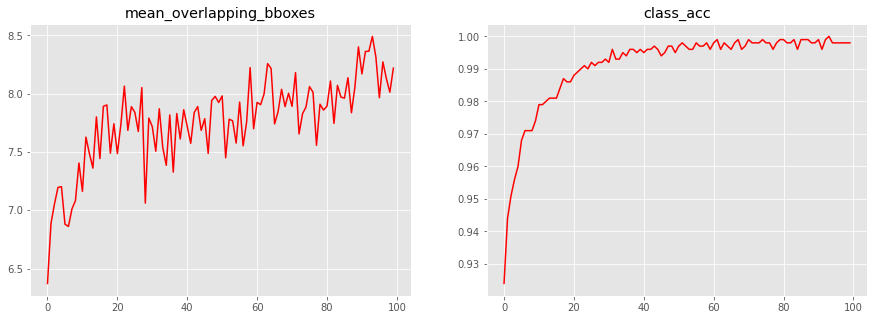

<Figure size 432x288 with 0 Axes>

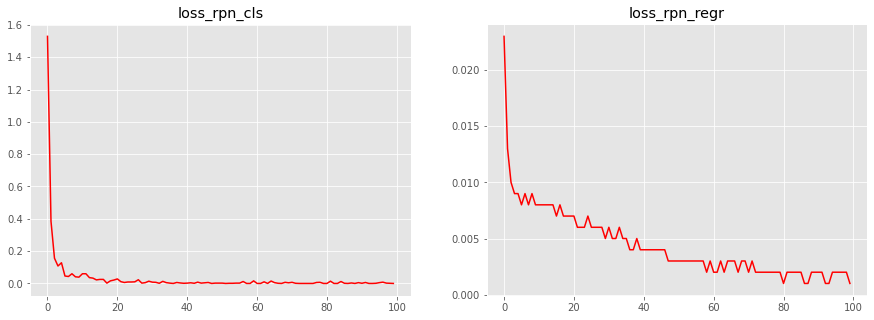

<Figure size 432x288 with 0 Axes>

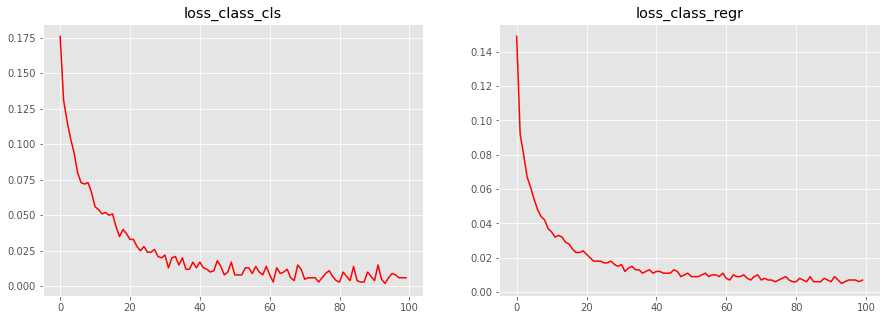

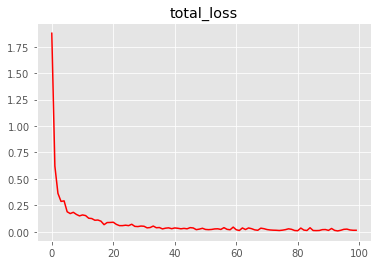

<Figure size 432x288 with 0 Axes>

In [244]:
record_df = pd.read_csv('E:/Faster_RCNN/models_oneClass/records.csv')

r_epochs = len(record_df)

plt.style.use("ggplot")
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(np.arange(0, r_epochs), record_df['mean_overlapping_bboxes'], 'r')
plt.title('mean_overlapping_bboxes')
plt.subplot(1,2,2)
plt.plot(np.arange(0, r_epochs), record_df['class_acc'], 'r')
plt.title('class_acc')

plt.show()
plt.savefig('E:/Faster_RCNN/models_oneClass/mob_acc.png')

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(np.arange(0, r_epochs), record_df['loss_rpn_cls'], 'r')
plt.title('loss_rpn_cls')
plt.subplot(1,2,2)
plt.plot(np.arange(0, r_epochs), record_df['loss_rpn_regr'], 'r')
plt.title('loss_rpn_regr')
plt.show()
plt.savefig('E:/Faster_RCNN/models_oneClass/rpn_loss.png')

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(np.arange(0, r_epochs), record_df['loss_class_cls'], 'r')
plt.title('loss_class_cls')
plt.subplot(1,2,2)
plt.plot(np.arange(0, r_epochs), record_df['loss_class_regr'], 'r')
plt.title('loss_class_regr')
plt.show()
plt.savefig('E:/Faster_RCNN/models_oneClass/class_loss.png')

plt.plot(np.arange(0, r_epochs), record_df['curr_loss'], 'r')
plt.title('total_loss')
plt.show()
plt.savefig('E:/Faster_RCNN/models_oneClass/total_loss.png')


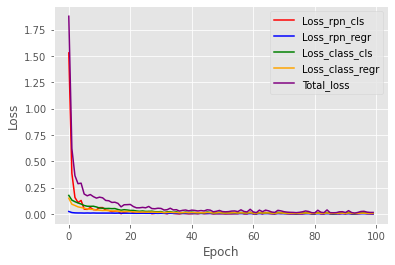

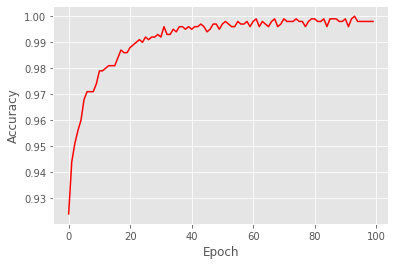

In [245]:
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, r_epochs), record_df['loss_rpn_cls'],'red', label="Loss_rpn_cls")
plt.plot(np.arange(0, r_epochs), record_df['loss_rpn_regr'],'blue', label="Loss_rpn_regr")
plt.plot(np.arange(0, r_epochs), record_df['loss_class_cls'],'green', label="Loss_class_cls")
plt.plot(np.arange(0, r_epochs), record_df['loss_class_regr'],'orange', label="Loss_class_regr")
plt.plot(np.arange(0, r_epochs),  record_df['curr_loss'],'purple', label="Total_loss")
#os.system("taskset -p 0xff %d" % os.getpid())
#plt.title("Training Loss and Metrics")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc="upper right")
plt.savefig('E:/Faster_RCNN/models_oneClass/model_all_loss.png')
plt.show()
plt.close()

plt.style.use("ggplot")
plt.plot(np.arange(0, r_epochs), record_df['class_acc'],'red', label="Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.savefig('E:/Faster_RCNN/models_oneClass/model_acc.png')
plt.show()
plt.close()

In [ ]:
import tensorflow as tf

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
gpus = tf.config.experimental.list_physical_devices('GPU')

for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)
print(gpus)

In [5]:
 def format_img_(img, C,preprocessing_function):
        img_min_side = float(C.im_size)
        (height,width,_) = img.shape

        if width <= height:
            f = img_min_side/width
            new_height = int(f * height)
            new_width = int(img_min_side)
        else:
            f = img_min_side/height
            new_width = int(f * width)
            new_height = int(img_min_side)
        fx = width/float(new_width)
        fy = height/float(new_height)
        img = cv2.resize(img, (new_width, new_height), interpolation=cv2.INTER_CUBIC)
        img = img[:, :, (2, 1, 0)] #bgr to RGB
        if preprocessing_function:
            img = preprocessing_function(img)
        # img = np.transpose(img, (2, 0, 1)) theano format
        img = np.expand_dims(img, axis=0)
        return img, fx, fy

In [6]:
def get_map1(pred, gt, f, threshold):
	T = {}
	P = {}
	fx, fy = f
	iou_list=[]
	for bbox in gt:
		bbox['bbox_matched'] = False
	pred_probs = np.array([s['prob'] for s in pred])
	box_idx_sorted_by_prob = np.argsort(pred_probs)[::-1]

	for box_idx in box_idx_sorted_by_prob:
		pred_box = pred[box_idx]
		pred_class = pred_box['class']
		pred_x1 = pred_box['x1']
		pred_x2 = pred_box['x2']
		pred_y1 = pred_box['y1']
		pred_y2 = pred_box['y2']
		pred_prob = pred_box['prob']
		if pred_class not in P:
			P[pred_class] = []
			T[pred_class] = []
		P[pred_class].append(pred_prob)
		  
		found_match = False
		for gt_box in gt:
			
			gt_class = gt_box['class']
			gt_x1 = gt_box['x1']/fx
			gt_x2 = gt_box['x2']/fx
			gt_y1 = gt_box['y1']/fy
			gt_y2 = gt_box['y2']/fy
			gt_seen = gt_box['bbox_matched']
			if gt_class != pred_class:
				continue
			if gt_seen:
				continue
			iou_map = iou((pred_x1, pred_y1, pred_x2, pred_y2), (gt_x1, gt_y1, gt_x2, gt_y2))
			iou_list.append(iou_map) 
			if iou_map >= threshold: ###0.5
				found_match = True
				gt_box['bbox_matched'] = True
				break
			else:
				continue
		T[pred_class].append(int(found_match))
	for gt_box in gt:
		if not gt_box['bbox_matched']:# and not gt_box['difficult']:
			if gt_box['class'] not in P:
				P[gt_box['class']] = []
				T[gt_box['class']] = []
			T[gt_box['class']].append(1)
			P[gt_box['class']].append(0)
	#import pdb
	#pdb.set_trace()
	#print("IOU_list:", iou_list)
	return T, P, iou_list

In [ ]:
############## Step 2: analyzing the test images using the trained model
# Import libraries
import os
import cv2
import time
import keras
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import average_precision_score
import pandas as pd

# The main entry point for this module
#def main():
# Create configuration
config = Config()
config.img_base_path = 'C:\\DATA\\Python-data\\open-images-v5\\imgs\\'
config.model_path = 'E:/Faster_RCNN/models_oneClass/training_model.h5'
config.use_horizontal_flips = False
config.use_vertical_flips = False
config.rot_90 = False
config.num_rois = 4
# Set the gpu to use
#setup_gpu('cpu')
#common.setup_gpu(0)
# Create a dictionary with classes and switch key values
classes = {'nasal_base': 0,  'bg': 1}
mappings = {v: k for k, v in classes.items()}
class_to_color = {mappings[v]: np.random.randint(0, 255, 3) for v in mappings}
print(mappings)
# Get inference models
model_rpn, model_classifier, model_classifier_only = get_inference_models(config, len(classes), weights_path=config.model_path)
# Get a list of test images
images = os.listdir('E:/Data/Input/test/images_')
# Randomize images to get different images each time
random.shuffle(images)
# If the box classification value is less than this, we ignore this box
bbox_threshold = 0.9 ###0.7
# Start visual evaluation
test_path='E:/Faster_RCNN/annotation_files/Data_test2.txt'
test_imgs, _, _ = get_data(test_path)
random.shuffle(test_imgs)
random.shuffle(test_imgs)

T = {}
P = {}
ALL_MAP_LIST = []
ALL_MAP_LIST1 = []
ALL_MAP= pd.DataFrame(columns=['Images', 'IOU'])
print("")
for i, name in enumerate(test_imgs): ###images
    # Limit the evaluation to 4 images
    #if i > 0:
        #break;
    # Print the name and start a timer
    #print(name)
    st = time.time()
    # Get the filepath
    filepath = name['filepath']
    head, tail = os.path.split(filepath)
    print(i, tail)
    
    img = cv2.imread(filepath)
    #filepath = os.path.join('E:/Data/Input/test/images_', name)
    # Get the image
    #img = cv2.imread(filepath)
    # Format the image
    #preprocessing_function = None
    #X_, fx, fy = format_img_(img, config,preprocessing_function)
    X, ratio = format_img(img, config)
    X = np.transpose(X, (0, 2, 3, 1))
    # Get output layer Y1, Y2 from the RPN and the feature maps F
    # Y1: y_rpn_cls
    # Y2: y_rpn_regr
    [Y1, Y2, F] = model_rpn.predict(X)
    # Get bboxes by applying NMS 
    # R.shape = (300, 4)
    R = rpn_to_roi(Y1, Y2, config, keras.backend.image_data_format(), overlap_thresh=0.7) ###0.7
    # Convert from (x1,y1,x2,y2) to (x,y,w,h)
    R[:, 2] -= R[:, 0]
    R[:, 3] -= R[:, 1]
    # Apply the spatial pyramid pooling to the proposed regions
    bboxes = {}
    probs = {}
    for jk in range(R.shape[0]//config.num_rois + 1):
        ROIs = np.expand_dims(R[config.num_rois*jk:config.num_rois*(jk+1), :], axis=0)
        if ROIs.shape[1] == 0:
            break
        if jk == R.shape[0]//config.num_rois:
            #pad R
            curr_shape = ROIs.shape
            target_shape = (curr_shape[0],config.num_rois,curr_shape[2])
            ROIs_padded = np.zeros(target_shape).astype(ROIs.dtype)
            ROIs_padded[:, :curr_shape[1], :] = ROIs
            ROIs_padded[0, curr_shape[1]:, :] = ROIs[0, 0, :]
            ROIs = ROIs_padded
        [P_cls, P_regr] = model_classifier_only.predict([F, ROIs])
        
        # Calculate bboxes coordinates on resized image
        for ii in range(P_cls.shape[1]):
            # Ignore 'bg' class
            if np.max(P_cls[0, ii, :]) < bbox_threshold or np.argmax(P_cls[0, ii, :]) == (P_cls.shape[2] - 1):
                continue
            # Get the class name
            cls_name = mappings[np.argmax(P_cls[0, ii, :])]
            if cls_name not in bboxes:
                bboxes[cls_name] = []
                probs[cls_name] = []
            (x, y, w, h) = ROIs[0, ii, :]
            cls_num = np.argmax(P_cls[0, ii, :])
            try:
                (tx, ty, tw, th) = P_regr[0, ii, 4*cls_num:4*(cls_num+1)]
                tx /= C.classifier_regr_std[0]
                ty /= C.classifier_regr_std[1]
                tw /= C.classifier_regr_std[2]
                th /= C.classifier_regr_std[3]
                x, y, w, h = layers.apply_regr(x, y, w, h, tx, ty, tw, th)
            except:
                pass
            bboxes[cls_name].append([config.rpn_stride*x, config.rpn_stride*y, config.rpn_stride*(x+w), config.rpn_stride*(y+h)])
            probs[cls_name].append(np.max(P_cls[0, ii, :]))
    all_dets = []
    all_det = []
    for key in bboxes:
        bbox = np.array(bboxes[key])
        new_boxes, new_probs = non_max_suppression_fast(bbox, np.array(probs[key]), overlap_thresh=0.6) ###0.2
        max_index=new_probs.argmax()
        boxes_ = new_boxes[max_index]
        """
        for jk in range(1):
            x1=boxes_[0]
            y1=boxes_[1]
            x2=boxes_[2]
            y2=boxes_[3]
        """
        for jk in range(new_boxes.shape[0]):
            (x1, y1, x2, y2) = new_boxes[jk,:]
            # Calculate real coordinates on original image
            (real_x1, real_y1, real_x2, real_y2) = get_real_coordinates(ratio, x1, y1, x2, y2)
            #cv2.rectangle(img,(real_x1, real_y1), (real_x2, real_y2), (int(class_to_color[key][0]), int(class_to_color[key][1]), int(class_to_color[key][2])),2)
            textLabel = '{0}: {1}'.format(key,int(100*new_probs[jk]))
            all_dets.append((key,100*new_probs[jk]))
            det = {'x1': x1, 'x2': x2, 'y1': y1, 'y2': y2, 'class': key, 'prob': new_probs[jk]}
            all_det.append(det)
            (retval,baseLine) = cv2.getTextSize(textLabel,cv2.FONT_HERSHEY_COMPLEX,1,1)
            textOrg = (real_x1, real_y1-0)
            #cv2.rectangle(img, (textOrg[0] - 5, textOrg[1]+baseLine - 5), (textOrg[0]+retval[0] + 5, textOrg[1]-retval[1] - 5), (0, 0, 0), 1)
            #cv2.rectangle(img, (textOrg[0] - 5,textOrg[1]+baseLine - 5), (textOrg[0]+retval[0] + 5, textOrg[1]-retval[1] - 5), (255, 255, 255), -1)
            textOrg_ = (20, 20)
            #cv2.putText(img, textLabel, textOrg_, cv2.FONT_HERSHEY_DUPLEX, 0.5, (0, 0, 0), 1)
            #cv2.imwrite(os.path.join('E:/faster/test',tail),img)
            
    #print('Elapsed time = {0}'.format(time.time() - st))
    
    plt.figure(figsize=(10,10))
    plt.grid()
    #plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
    #plt.savefig('E:/faster/test/' + tail + '.jpg')
    #plt.show()
    fx=1
    fy=1
    #print(all_det, name['bboxes'],"** Len det:", len(all_det))
    
    t, p, iou_list = get_map1(all_det, name['bboxes'], (fx, fy), 0.95)
    gt_box=name['bboxes']
    
    #print (t,p, iou_list)
    if len(iou_list)!=0:
        max_index=iou_list.index(max(iou_list))
        #print(max_index,"*****", all_det[max_index],gt_box)
        cv2.rectangle(img,(gt_box[0]['x1'], gt_box[0]['y1']), (gt_box[0]['x2'], gt_box[0]['y2']), (255,0,0),2)
        cv2.rectangle(img,(all_det[max_index]['x1'], all_det[max_index]['y1']), (all_det[max_index]['x2'], all_det[max_index]['y2']), (0,0,0),2)
        textOrg_ = (20, 20)
        textLabel = '{0}: {1}, {2}: {3}'.format("IOU",int(100*max(iou_list)),"Prob", int(100*all_det[max_index]['prob']))
        cv2.putText(img, textLabel, textOrg_, cv2.FONT_HERSHEY_DUPLEX, 0.5, (255, 255, 255), 1)
        cv2.imwrite(os.path.join('E:/Faster_Output/test',tail),img)
        ALL_MAP=ALL_MAP.append({'Images': tail, 'IOU': max(iou_list)}, ignore_index=True)
  
        y_true = np.array([1,  0])
        y_scores = np.array([max(iou_list), 0])
        ans_=average_precision_score(y_true, y_scores)
        ALL_MAP_LIST1.append(round(ans_,4))
        
    for key in t.keys():
        if key not in T:
            T[key] = []
            P[key] = []
        T[key].extend(t[key])
        P[key].extend(p[key])
    all_aps = []
    for key in T.keys():
        ap = average_precision_score(T[key], P[key])
        print('{} AP: {}'.format(key, ap))
        all_aps.append(ap)
    #print('mAP = {}'.format(np.mean(np.array(all_aps))))
    ALL_MAP_LIST.append(round(np.mean(np.array(all_aps)),4))
ALL_MAP.to_csv('E:/Faster_RCNN/models_oneClass/ALL_MAP.csv')    
# Tell python to run main method
#if __name__ == "__main__": main()